<h1><center>Adults Dataset</center></h1>

# Machine Learning 1 - Lab 3: Clustering

### Authors:
Richard Kim <br> Connor Dobbs<br> Joaquin Dominguez

In [145]:
# Import relevant packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from matplotlib.pyplot import xticks

# Hide deprecation warnings
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=DeprecationWarning)

In [146]:
# Full, clean dataset with original attributes
df_clean = pd.read_csv('https://raw.githubusercontent.com/j-dominguez9/ML1_Proj1/main/Data/census_clean.csv')

## Business Understanding

### Purpose of Data:

This data was originally collected as part of the 1994 US Census. According to census.gov, The purpose of the Census is for the government to better understand the demographics of the people living there and where a variety of metrics are trending. This information is used to help determine where and how to allocate federal and state funding. The raw data was then extracted and compiled by Barry Becker and is available on UCI's machine learning repository here: https://archive.ics.uci.edu/ml/datasets/adult

### Evaluation Metrics

Below are the metrics we will be using for classifying income, a binary variable that identifies whether an individual earns less than or more than 50K. 

Accuracy: <br>
> The first metric we will be using is Accuracy. By accuracy, we mean "the ratio of number of correct predictions to the total number of input samples."[^1] 

> Accuracy = Number of Correct Predictions/Total Number of Predictions Made

> By balancing our datset with respect to our target variable, we took measures to maximize the value that this metric provides. For our dataset, accuracy will give us a measure of how maany instances are correctly classified as >=50K  or <50K, in any given model.

Sensitivity/Recall: <br>

> Recall measures the proportion of actual positives that  were identified correctly[^3].

> Recall = True Positive/(True Positive + False Negative)

> For our dataset, Recall will give us a measure of how many of the instances that were actually >=50K were classified as such by the model.

Specificity: <br>
> Inversely to the previous measure, specificity (True Negative Rate) refers to the "proportion of negative data points that are correctly considered as negative, with respect to all negative data points."[^4]

> Sensitivity = True Negative/(True Negative + False Positive)

> For our dataset, specificity measures the proportion of actual <50K classified as such by a given model.

While we will look at the above metrics for income classifcation, the primary metric we will be looking to optimize in this case is Sensitivity, as it is the more useful metric in many contexts because it is harder to predict because it is a minority of people, and because predicting high earners could be used for things like targeted marketing campaigns for high margin products. 

[^1]: https://towardsdatascience.com/metrics-to-evaluate-your-machine-learning-algorithm-f10ba6e38234
[^2]: https://developers.google.com/machine-learning/crash-course/classification/precision-and-recall
[^3]: https://developers.google.com/machine-learning/crash-course/classification/precision-and-recall
[^4]: https://towardsdatascience.com/metrics-to-evaluate-your-machine-learning-algorithm-f10ba6e38234

## Data Understanding 1

### Data Meaning and Type

The dataset contains 48,842 observations with 15 total variables, for a total of 732,630 data elements. The below list contains each attribute definition based on the UCI archive and data type determined in the code below. 

* age (integer between 17 and 90): The age of the individaul observed.
* workclass (object with 8 levels): The employment type of the individual. For example if they are self employed or government employed. 
* fnlwgt (integer between ~12,285 and ~1,490,400): The definition of this is slightly unclear, but generally seems to be the number of people the census estimates the observation represents. 
* education (object with 16 levels): Category of education completed by observation.
* educational-num (integer between 1 and 16): Numeric value of education completed by observation. 
* marital-status (object with 7 levels): Marital status of individual, including if their spouse is in the armed forces or absent.
* occupation (object with 14 levels): The type of work the indidividual does.
* relationship (object with 6 levels): Relationship individual has with others in the househould, similar to marital status but includes other categories potentially more applicable to younger observations such as ownly child or not in a family. 
* race (object with 5 levels): Race of indivdual
* sex (object with 2 levels): Sex of individual, male or female
* capital-gain (integer between 0 and 99,999): Self-reported capital gains by the indidivdual for the most recent year.
* capital-loss (integer between 0 and 4,356): Self-reported capital losses by the individual for the most recent year. 
* hours-per-week (integer between 1 and 99): Self-reported number of hours worked per week by the individual.
* native-country (object with 42 levels): Native country of the individual
* income (object with 2 levels): Self-reported income class for the individual, either greater or less than $50k.

In [147]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('https://raw.githubusercontent.com/j-dominguez9/ML1_Proj1/main/Data/adult.csv') # read in the csv file

#replace question mark values as na
df = df.replace('?', np.NaN)

df.info()

# below method of finding count of unique values by column from: https://www.geeksforgeeks.org/how-to-count-distinct-values-of-a-pandas-dataframe-column/

n = df.nunique(axis=0)
  
print("No.of.unique values in each column :\n",
      n)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   age              48842 non-null  int64 
 1   workclass        46043 non-null  object
 2   fnlwgt           48842 non-null  int64 
 3   education        48842 non-null  object
 4   educational-num  48842 non-null  int64 
 5   marital-status   48842 non-null  object
 6   occupation       46033 non-null  object
 7   relationship     48842 non-null  object
 8   race             48842 non-null  object
 9   gender           48842 non-null  object
 10  capital-gain     48842 non-null  int64 
 11  capital-loss     48842 non-null  int64 
 12  hours-per-week   48842 non-null  int64 
 13  native-country   47985 non-null  object
 14  income           48842 non-null  object
dtypes: int64(6), object(9)
memory usage: 5.6+ MB
No.of.unique values in each column :
 age                   74
workclass    

### Missing Values

There are missing values in 3 of the columns: workclass, occupation, and native-country. 

While a missing value in occupation could indicate unemployed, it would then be expected to better align with the count of workclass in the level of "never-worked" and/or "Without pay", however this is not the case. 

It is also seen that all 2,799 missing workclass values are also missing an occupation. This pattern might suggest that they are unemployed, however they are still reporting working hours as well as at times income > $50k. 

The most likely explanation is a data collection or data quality issue for these two fields, since everyone should have a native country and class of work. With no clear pattern to these missing values, we will drop these records rather than trying to impute and potentially bias the dataset.  

In [148]:
# count missing values in each column
df.isna().sum()

age                   0
workclass          2799
fnlwgt                0
education             0
educational-num       0
marital-status        0
occupation         2809
relationship          0
race                  0
gender                0
capital-gain          0
capital-loss          0
hours-per-week        0
native-country      857
income                0
dtype: int64

### Duplicate Values

There were 47 duplicate values in the dataset. While duplicates are unlikely, they are possible that two people responded with the same information to this set of census questions. While the data may be real, it still poses a risk of biasing the dataset towards these observations, when they contain the same information. Because of this, these 47 records are also removed. 

In [149]:
bool_series = df.duplicated(keep='first')

#count duplicates
np.shape(df[bool_series])

#view duplicates
df[bool_series]

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
864,24,Private,194630,Bachelors,13,Never-married,Prof-specialty,Not-in-family,White,Male,0,0,35,United-States,<=50K
11189,37,Private,52870,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,40,United-States,<=50K
11212,29,Private,36440,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Female,0,0,40,United-States,<=50K
13848,30,Private,180317,Assoc-voc,11,Divorced,Machine-op-inspct,Not-in-family,White,Male,0,0,40,United-States,<=50K
15960,18,Self-emp-inc,378036,12th,8,Never-married,Farming-fishing,Own-child,White,Male,0,0,10,United-States,<=50K
18476,39,Private,184659,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,<=50K
19399,19,Private,130431,5th-6th,3,Never-married,Farming-fishing,Not-in-family,White,Male,0,0,36,Mexico,<=50K
19726,41,Private,116391,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,40,United-States,>50K
20606,25,Private,308144,Bachelors,13,Never-married,Craft-repair,Not-in-family,White,Male,0,0,40,Mexico,<=50K
21162,25,Private,308144,Bachelors,13,Never-married,Craft-repair,Not-in-family,White,Male,0,0,40,Mexico,<=50K


### Outliers

In checking for outliers, a preliminary visual inspection was used on the distributions of the numeric columns. Other methods considered were IQR and Z-Score based methods, however, since the numeric fields in this dataset are all heavily skewed toward a specific value (such as 40 hour work weeks or 0 capital gains), numerous realistic values are flagged by conventional measures. During the modeling effort, it could be worth investigating scaling these measures or turning them into factors, particularly with capital-gain, where the data suggests that any gains over 99,999 are all classified as a 99,999. 

<AxesSubplot:xlabel='capital-gain'>

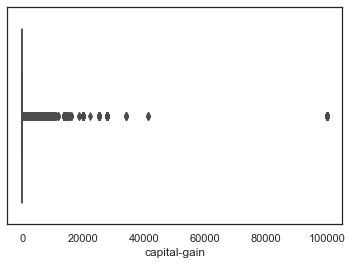

In [150]:
from scipy import stats

z = np.abs(stats.zscore(df['hours-per-week']))

np.shape(np.where(z > 4))

sns.boxplot(df['capital-gain'])

<AxesSubplot:xlabel='capital-loss'>

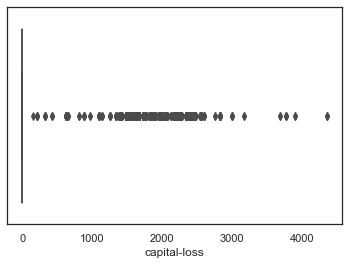

In [151]:
sns.boxplot(df['capital-loss'])

<AxesSubplot:xlabel='fnlwgt'>

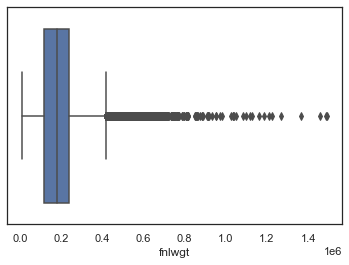

In [152]:
sns.boxplot(df['fnlwgt'])

<AxesSubplot:xlabel='hours-per-week'>

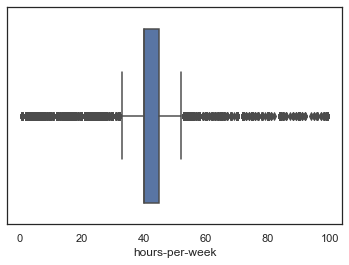

In [153]:
sns.boxplot(df['hours-per-week'])

In [154]:
df[df['capital-gain'] > 50000]

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
83,44,Self-emp-inc,223881,HS-grad,9,Married-civ-spouse,Craft-repair,Husband,White,Male,99999,0,50,NaN,>50K
346,39,Private,198654,HS-grad,9,Divorced,Exec-managerial,Unmarried,Black,Female,99999,0,40,United-States,>50K
357,50,Self-emp-not-inc,165001,Prof-school,15,Married-civ-spouse,Prof-specialty,Husband,White,Male,99999,0,80,United-States,>50K
418,54,Self-emp-inc,159219,Prof-school,15,Married-civ-spouse,Prof-specialty,Husband,White,Male,99999,0,40,United-States,>50K
692,41,Private,191547,Masters,14,Married-civ-spouse,Exec-managerial,Husband,White,Male,99999,0,55,United-States,>50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48109,47,Private,155664,Masters,14,Married-civ-spouse,Exec-managerial,Husband,White,Male,99999,0,55,United-States,>50K
48253,43,Self-emp-inc,62026,Prof-school,15,Married-civ-spouse,Exec-managerial,Husband,White,Male,99999,0,40,United-States,>50K
48371,66,Private,115498,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,99999,0,55,NaN,>50K
48519,47,Private,294913,Prof-school,15,Married-civ-spouse,Exec-managerial,Husband,White,Male,99999,0,40,United-States,>50K


## Data Understanding 2

### Visualize Attributes
#### Education
Via domain knowledge, we suspect education to be a strong predictor for income; thus, it will be the first variable we will visualize. To avoid manipulating the dataset in a manner that may affect future models, we will run all visualizations through a copy of the dataset (df_viz). For the first variable, Education, we made sure it was set as categorical, then releveled the factors, such that they are outlined from least to highest vis-a-vis education level for easier interpretation. The histogram shows an unbalanced distribution, such that all levels don't have the same number of instances. When modeling, it will be prudent to create more pragmatic levels (e.g., "< High school", "HS-college/trade", "Bachelor's", "Post-high school") to address this concern.

In [155]:
df_clean.head()

,Unnamed: 0,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,5,34,Private,198693,10th,6,Never-married,Other-service,Not-in-family,White,Male,0,0,30,United-States,<=50K


[Text(0.5, 1.0, 'Distribution of Education')]

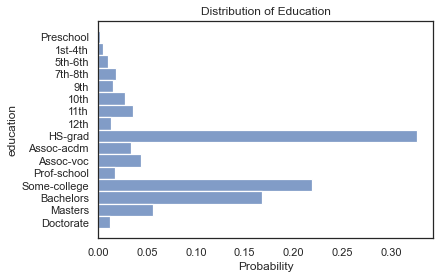

In [156]:
# Set variable as categorical, reorder factor levels form least to most education
sns.set_theme(style='white', palette='deep')

df_viz = df_clean.copy()

df_viz["education"] = df_viz["education"].astype('category')

df_viz["education"] = df_viz["education"].cat.as_ordered()

df_viz["education"] = df_viz["education"].cat.set_categories(['Preschool', '1st-4th', '5th-6th', '7th-8th', '9th', '10th', '11th', '12th', 'HS-grad', 'Assoc-acdm', 'Assoc-voc', 'Prof-school', 'Some-college', 'Bachelors', 'Masters', 'Doctorate'], ordered=True)

sns.histplot(data = df_viz, y = "education", discrete = True, stat = 'probability', alpha = 0.7, legend = False).set(title="Distribution of Education")

#### Age
Since Age is continous variable, there is no need to rearrange levels of factors, as was done for Education. A visual inspection of the histogram below suggests the distribution to have a right skew. There also seems to be an abnormally high occurrence of instances of age 36, specifically 1283 of them. A transformation may be beneficial for further statistical anaylses and modeling. The attribute ranges from 17 to 90, with a mean of 38.6. The boxplot allows a different perspective by which we can see the right-skew and the presence of outliers outside of the inter-quartile range (IQR).

Highest Ocurrence: [(36, 1283)]


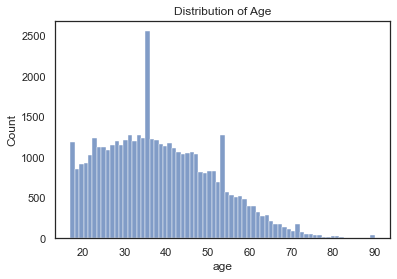

In [157]:
# Histogram
sns.histplot(data = df_viz, x = "age", alpha = 0.7).set(title="Distribution of Age")

# Find instance with highest occurences, code based on: https://www.codegrepper.com/code-examples/python/python+element+with+max+count
from collections import Counter

c = Counter(df_viz["age"])

print("Highest Ocurrence:", c.most_common(1))

#### Income
Income is one of the response variables being used, so it is essential to be aware of the distribution found therein. In this case, we have a significantly unbalanced dataset with respect to income--this, unfortunately, may compromise the accuracy and utility of models derived from this dataset. There are methods to balance the data, however, that may be used prior to modeling, if found prudent to do so. Although this distribution may reflect the reality of income distribution in the US in 1994, a balanced distribution allows us to lower the No Information Rate, which makes the evaluative metrics of a model more valuable for prediction and classification purposes. We are treating this variable as discrete, despite Income being numeric in nature; thus, we defined it as such prior to plotting. A simple bar graph/histogram is effective at clearly providing the insights discussed above.

Percentages by Income:
 <=50K    75.203099
>50K     24.796901
Name: income, dtype: float64


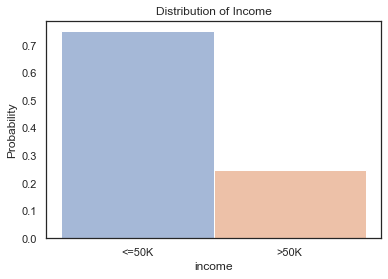

In [158]:
df_viz["income"] = df_viz["income"].astype('category')

df_viz["income"] = df_viz["income"].cat.as_ordered()

sns.histplot(data = df_viz, x = 'income', discrete = True, stat = 'probability', hue = 'income', legend = False).set(title="Distribution of Income")

# Outline percentages by income, code based on: https://stackoverflow.com/questions/53690279/pandas-percentage-count-of-categorical-variable
print("Percentages by Income:\n", (df_viz["income"].value_counts() / len(df_viz["income"]))*100)

### Explore Joint Attributes
In this section, we will begin looking at relationships between attributes. 

#### Income vs. Age
Via domain knowledge and common sense, we suspect Age to be a strong predictor of Income. This violin plot allows us to very clearly see the diffences between the IQR of both income groups, with respect to gender. The group with an annual income greater than $50K appears to have an IQR that is considerably higher on the age axis. For both Male and Female cases, we see a considerable shift along the age axis between the Income groups.

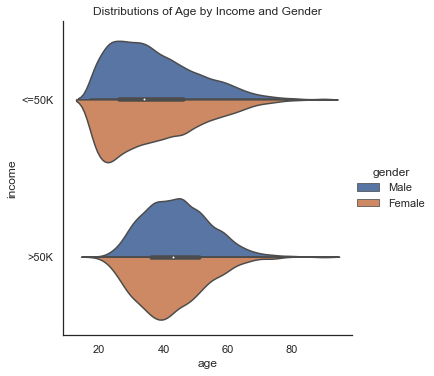

In [159]:
sns.catplot(x="age", y="income", hue="gender", kind="violin", split = True, data=df_viz).set(title= "Distributions of Age by Income and Gender")

### Income vs. Education
As mentioned, we suspect Education to be a strong predictor for Income. The variable labeled Educational-num has the categories ranked in education levels, so we can use that for visualization purposes to examine the relationship.

This boxplot depicts the distributions found in both income groups with respect to Education. Those in the <=50K group seem to percolate within an education level between 8-12, whereas the higher income group has a wider range and appears to be hgiher up along the educational-num axis, supporting our initial suspicion.

[Text(0.5, 1.0, 'Distribution of Income by Education')]

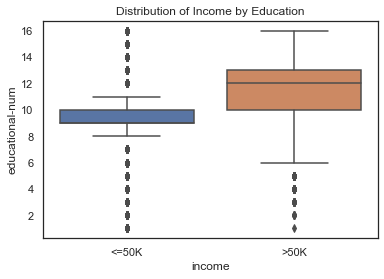

In [160]:
sns.boxplot(data= df_viz, x = "income", y = "educational-num").set(title="Distribution of Income by Education")

## Modeling and Evaluation 1

### Kmodes Clustering

Since there are so many categorical variables in this dataset, we will be primarily modeling with kmodes clustering method. Kmodes defines clusters based on matching categories between data points, rather than off Euclidean distance in more typical Kmeans methods. 

Package documentation from: https://pypi.org/project/kmodes/
Modeled example notebook referenced: https://www.kaggle.com/code/ashydv/bank-customer-clustering-k-modes-clustering


### Methods

Two Kmodes methods will be tried with various degrees of initilization. The first method is Cao, which chooses initial groups based on density, as a result, putting more emphasis on variables with few category. The other method, Huang's, selects the first k objects from the datset as initial cluster centers. With the Cao method, we used a K value of 3, based on the cost efficiency explored in the below code. Three groups is also a potentially useful number of clusters for easily understanding major differences. For Huang, we used a k of 7, partialy to take advantage of a higher number of starting cluster centers and also to attempt to get more "niche" homogenous groups. 

Info from: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5753022/

In [161]:
# setup
import warnings

warnings.filterwarnings('ignore')
X = df_clean.copy()

In [162]:
# preprocessing, encoding categorical data for analysis
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
X = X.apply(le.fit_transform)
X.head()

,Unnamed: 0,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,0,8,2,18119,1,6,4,6,3,2,1,0,0,39,38,0
1,1,21,2,3913,11,8,2,4,0,4,1,0,0,49,38,0
2,2,11,1,23770,7,11,2,10,0,4,1,0,0,39,38,1
3,3,27,2,10474,15,9,2,6,0,2,1,96,0,39,38,1
4,4,17,2,15397,0,5,4,7,1,4,1,0,0,29,38,0


In [163]:
# Importing Library
from kmodes.kmodes import KModes
from sklearn import preprocessing

We first determine what would be the optimal k based on cost below. 

In [164]:
#choose optimal k based on cost
cost = []
for num_clusters in list(range(1,10)):
    kmode = KModes(n_clusters=num_clusters, init = "Cao", n_init = 1, verbose=1)
    kmode.fit_predict(X)
    cost.append(kmode.cost_)

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 0, cost: 362653.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 6526, cost: 326201.0
Run 1, iteration: 2/100, moves: 299, cost: 326201.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 8294, cost: 314056.0
Run 1, iteration: 2/100, moves: 542, cost: 314056.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 8584, cost: 309078.0
Run 1, iteration: 2/100, moves: 1494, cost: 309076.0
Run 1, iteration: 3/100, moves: 0, cost: 309076.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 8987, cost: 304910.0
Run 1, iteration: 2/100, moves: 0, cost: 304910.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
R

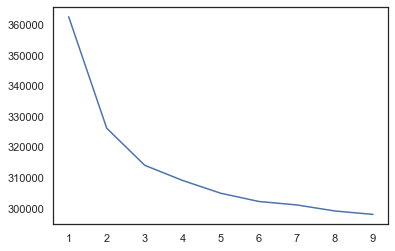

In [165]:
y = np.array([i for i in range(1,10,1)])
plt.plot(y,cost)

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 8294, cost: 314056.0
Run 1, iteration: 2/100, moves: 542, cost: 314056.0


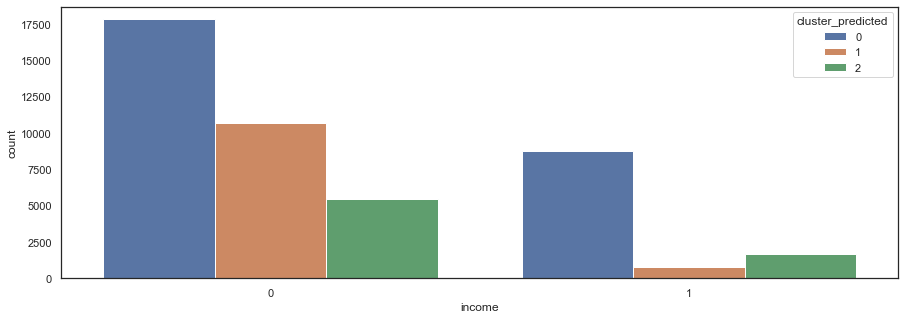

In [166]:
kmodes_seed = 111

#KModes Cluster 1
km_cao = KModes(n_clusters = 3, init = "Cao", n_init = 1, verbose = 1, random_state=kmodes_seed)
fitClusters_cao = km_cao.fit_predict(X)
clusterCentroidsDf = pd.DataFrame(km_cao.cluster_centroids_)
clusterCentroidsDf.columns = X.columns

clustersDf = pd.DataFrame(fitClusters_cao)
clustersDf.columns = ['cluster_predicted']
combinedDfcao = pd.concat([X, clustersDf], axis = 1).reset_index()
combinedDfcao = combinedDfcao.drop(['index', 'Unnamed: 0'], axis = 1)


plt.subplots(figsize = (15,5))
sns.countplot(x=combinedDfcao['income'],order=combinedDfcao['income'].value_counts().index,hue=combinedDfcao['cluster_predicted'])
plt.show()

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 10288, cost: 288915.0
Run 1, iteration: 2/100, moves: 2, cost: 288915.0


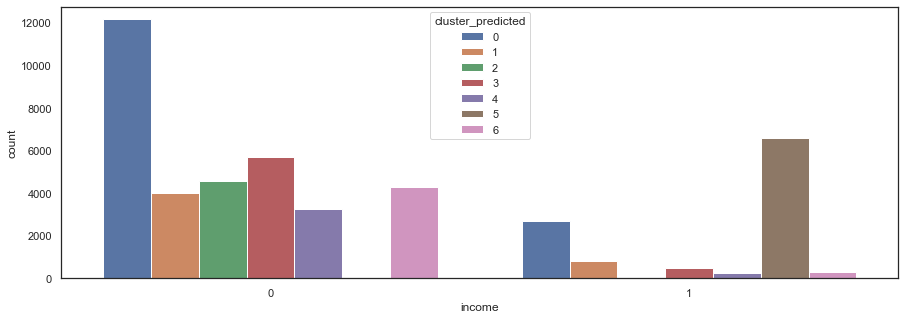

In [167]:
#KModes Cluster 2
km_huang = KModes(n_clusters = 7, init = "Huang", n_init = 1, verbose = 1, random_state=kmodes_seed)
fitClusters_huang = km_huang.fit_predict(X)
clusterCentroidsDf = pd.DataFrame(km_huang.cluster_centroids_)
clusterCentroidsDf.columns = X.columns

#combine predictions with original DF
clustersDf = pd.DataFrame(fitClusters_huang)
clustersDf.columns = ['cluster_predicted']
combinedDfhuang = pd.concat([X, clustersDf], axis = 1).reset_index()
combinedDfhuang = combinedDfhuang.drop(['index', 'Unnamed: 0'], axis = 1)

plt.subplots(figsize = (15,5))
sns.countplot(x=combinedDfhuang['income'],order=combinedDfhuang['income'].value_counts().index,hue=combinedDfhuang['cluster_predicted'])
plt.show()

## Modeling and Evaluation 2

Using attributes we considered to be important in our dataset, we performed a 10-fold cross-validation with a Random Forest classifier. We chose to proceed with an 80/20 train/test split. These average accuracy and standard deviation scores were then used as a baseline by which we can compare our other models. 

In [168]:
#importing libraries
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import ShuffleSplit
from sklearn import model_selection
from sklearn.metrics import make_scorer, accuracy_score, recall_score

In [169]:
### split data 80/20 with 10 cross-validation
num_cv_iterations = 10
cv_object = ShuffleSplit(n_splits=num_cv_iterations,
                         test_size  = 0.2, random_state = 42)

This initial classification model yielded a decent accuracy score of 80.6% with a standard deviation of 0.32. Our ideal goal in evaluating our models is to achieve an accuracy higher than 80.6% and a standard deviation lower than 0.32.

In [170]:
# Using Important Variables from before, Accuracy and Standard Deviation

# code for evaluation metrics obtained from stack overflow linked below
# https://stackoverflow.com/questions/47704133/how-to-define-specificity-as-a-callable-scorer-for-model-evaluation
y = X['income']
xvars = X[['age','education','marital-status','gender','hours-per-week']]

clf = RandomForestClassifier(n_estimators=150, random_state=1)

acc = cross_val_score(clf, xvars, y=y, cv=cv_object, scoring=make_scorer(accuracy_score))
sens = cross_val_score(clf, xvars, y=y, cv=cv_object, scoring=make_scorer(recall_score))
spec = cross_val_score(clf, xvars, y=y, cv=cv_object, scoring=make_scorer(recall_score,pos_label=0))

print ("Average accuracy = ", acc.mean()*100, "+-", acc.std()*100)
print ("Average sensitivity = ", sens.mean()*100)
print ("Average specificity = ", spec.mean()*100)

Average accuracy =  80.59878251245159 +- 0.32072390692623737
Average sensitivity =  54.2691456193094
Average specificity =  89.22043554855122


We begin by looking at how the Cao model performed. We see here that the accuracy score has dropped from 80% to 75%, and the standard deviation had a slight increase. These results are not surprising when we see that the average sensitivity score was at 0%. This implies that all observations were classified as <50K income. 

In [171]:
# KModes Cluster 1 (Cao), Accuracy and Standard Deviation
y = combinedDfcao['income']
xvars = combinedDfcao[['cluster_predicted']]

clf = RandomForestClassifier(n_estimators=150, random_state=1)

acc = cross_val_score(clf, xvars, y=y, cv=cv_object, scoring=make_scorer(accuracy_score))
sens = cross_val_score(clf, xvars, y=y, cv=cv_object, scoring=make_scorer(recall_score))
spec = cross_val_score(clf, xvars, y=y, cv=cv_object, scoring=make_scorer(recall_score,pos_label=0))

print ("Average accuracy = ", acc.mean()*100, "+-", acc.std()*100)
print ("Average sensitivity = ", sens.mean()*100)
print ("Average specificity = ", spec.mean()*100)

Average accuracy =  75.33370226895407 +- 0.34301014306273686
Average sensitivity =  0.0
Average specificity =  100.0


Next, we look at the Huang model's performance. Here, the accuracy has increased from 80% to 89%, while the standard devation saw a reduction from 0.32 to 0.26. Additionally, we see that the average sensitivity score has increased from 54% to 58% and specificity has reached 100%. Although the sensitivity score improvement may seem minimal, this increase may be more meaningful in practical use. As we stated earlier, there is an imbalance in the data such that most individuals earn less than 50K. Thus, attaining a high sensitivity score to predict the high earners is more difficult. Overall, all of our evaluation metrics in this model have seen an improvement. 

In [172]:
# KModes Cluster 2 (Huang), Accuracy and Standard Deviation
y = combinedDfhuang['income']
xvars = combinedDfhuang[['cluster_predicted']]

clf = RandomForestClassifier(n_estimators=150, random_state=1)

acc = cross_val_score(clf, xvars, y=y, cv=cv_object, scoring=make_scorer(accuracy_score))
sens = cross_val_score(clf, xvars, y=y, cv=cv_object, scoring=make_scorer(recall_score))
spec = cross_val_score(clf, xvars, y=y, cv=cv_object, scoring=make_scorer(recall_score,pos_label=0))

print ("Average accuracy = ", acc.mean()*100, "+-", acc.std()*100)
print ("Average sensitivity = ", sens.mean()*100)
print ("Average specificity = ", spec.mean()*100)

Average accuracy =  89.79302711676812 +- 0.2641908798731291
Average sensitivity =  58.622785279416334
Average specificity =  100.0


Based on these results, we would conclude that the Huang model with 7 clusters performed much better than the base Random Classifier model and the Cao model with 3 clusters. However, given that the clusters were created with the target variable included, these results should be taken with caution. 

For the analyses conducted above, metrics were obtained as a demonstration to show what clustering is capable of adding to a classification problem. If a proper evaluation of classification performance is desired, clusters should exclude the predicted variable ('income' in this case). It was left in for this analysis because it is an important variable in creating useful "groups" for use cases discusted in the evaluation section 4. 

## Modeling and Evaluation 3

## Plotting

For plotting, to obtain a better understanding of how the clusters are grouping different attributes, we will explore what was previosly shown as the most important variables in the logistic regression classification of income. Findings from the plots are discussed in the following section.

### Age

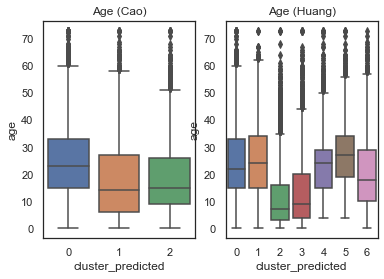

In [173]:
from matplotlib import rcParams
#plt.subplots(figsize = (15,5))
fig, ax = plt.subplots(1, 2)
rcParams['figure.figsize'] = 20,8
sns.boxplot(data = combinedDfcao, x='cluster_predicted',y = 'age', ax=ax[0]).set(title="Age (Cao)")
sns.boxplot(data = combinedDfhuang, x='cluster_predicted',y = 'age', ax=ax[1]).set(title="Age (Huang)")
#sns.histplot(data = df_viz, x = 'income', discrete = True, stat = 'probability', hue = 'income', legend = False).set(title="Distribution of Income")
fig.show()

### Income

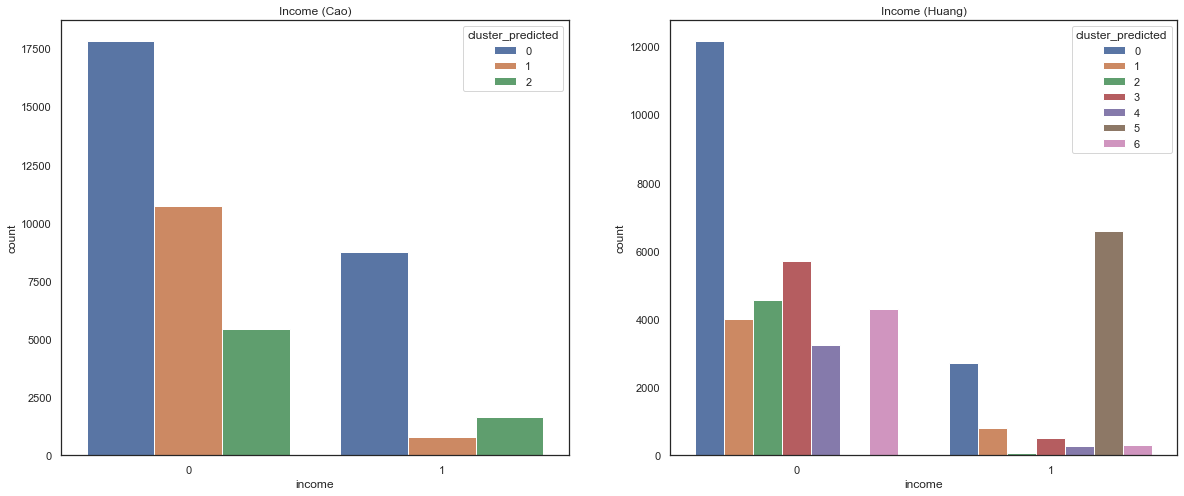

In [174]:
#plt.subplots(figsize = (15,5))
fig, ax = plt.subplots(1,2)
rcParams['figure.figsize'] = 30,8
sns.countplot(x=combinedDfcao['income'],order=combinedDfcao['income'].value_counts().index,hue=combinedDfcao['cluster_predicted'], ax = ax[0]).set(title="Income (Cao)")
sns.countplot(x=combinedDfhuang['income'],order=combinedDfhuang['income'].value_counts().index,hue=combinedDfhuang['cluster_predicted'], ax = ax[1]).set(title="Income (Huang)")
fig.show()

### Hours Worked

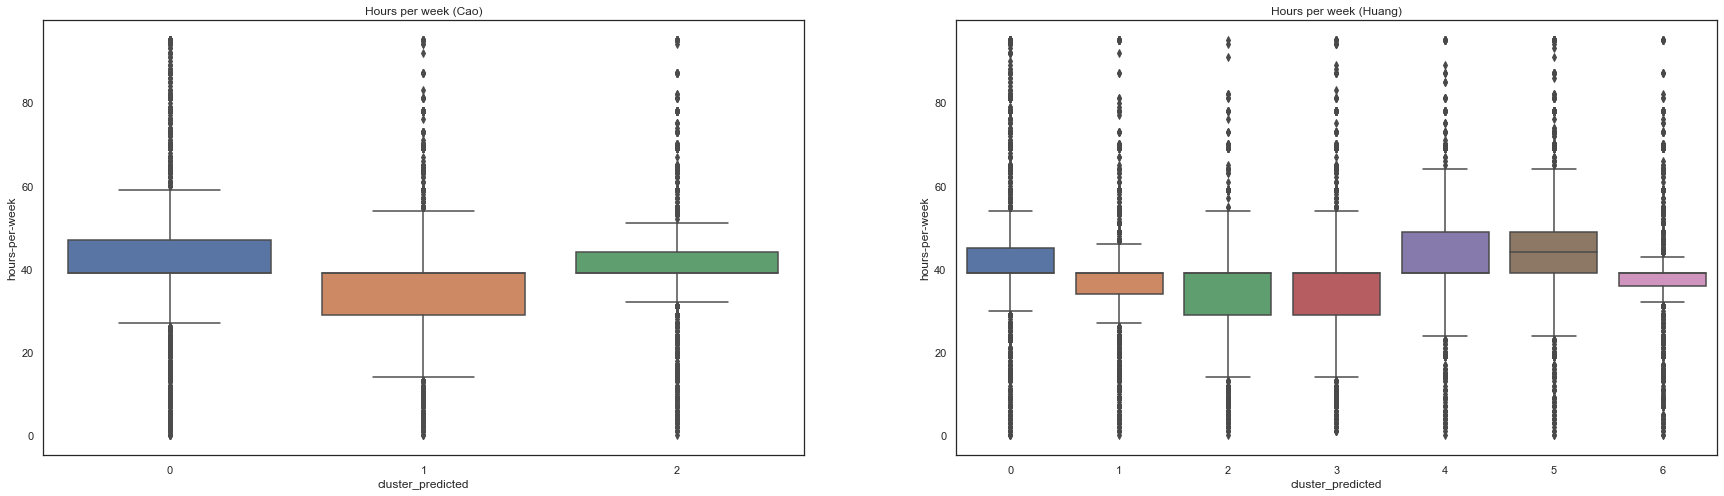

In [175]:
fig, ax = plt.subplots(1,2)
rcParams['figure.figsize'] = 20,7
sns.boxplot(x=combinedDfcao['cluster_predicted'],y = combinedDfcao['hours-per-week'], ax = ax[0]).set(title="Hours per week (Cao)")
sns.boxplot(data = combinedDfhuang, x='cluster_predicted', y = 'hours-per-week', ax = ax[1]).set(title="Hours per week (Huang)")
fig.show()

### Education

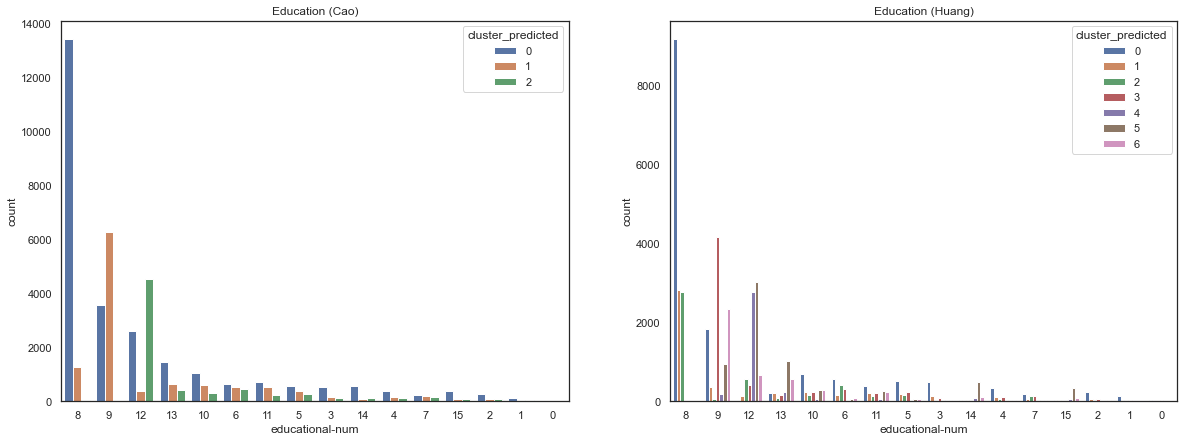

In [176]:
fig, ax = plt.subplots(1,2)
rcParams['figure.figsize'] = 30,8
sns.countplot(x=combinedDfcao['educational-num'],order=combinedDfcao['educational-num'].value_counts().index,hue=combinedDfcao['cluster_predicted'], ax = ax[0]).set(title="Education (Cao)")
sns.countplot(x=combinedDfhuang['educational-num'],order=combinedDfhuang['educational-num'].value_counts().index,hue=combinedDfhuang['cluster_predicted'], ax = ax[1]).set(title="Education (Huang)")
fig.show()

### Race

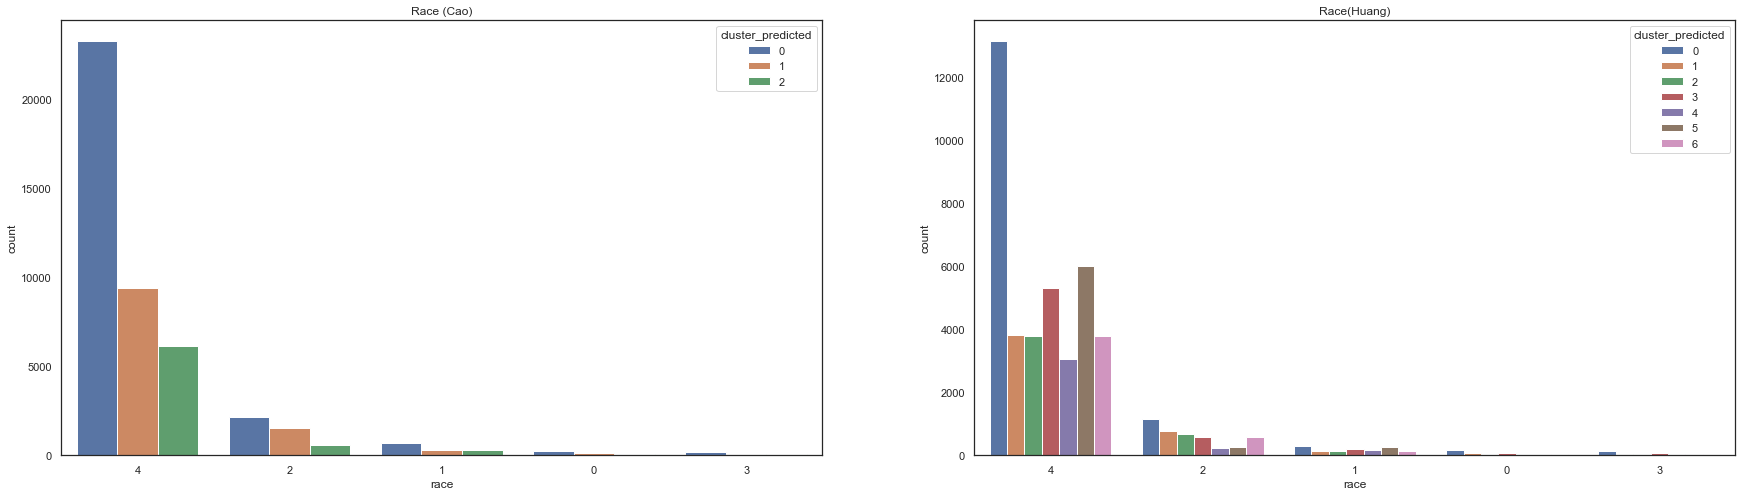

In [177]:
fig, ax = plt.subplots(1,2)
rcParams['figure.figsize'] = 30,8
sns.countplot(x=combinedDfcao['race'],order=combinedDfcao['race'].value_counts().index,hue=combinedDfcao['cluster_predicted'], ax = ax[0]).set(title="Race (Cao)")
sns.countplot(x=combinedDfhuang['race'],order=combinedDfhuang['race'].value_counts().index,hue=combinedDfhuang['cluster_predicted'], ax = ax[1]).set(title="Race(Huang)")
fig.show()

### Marital Status

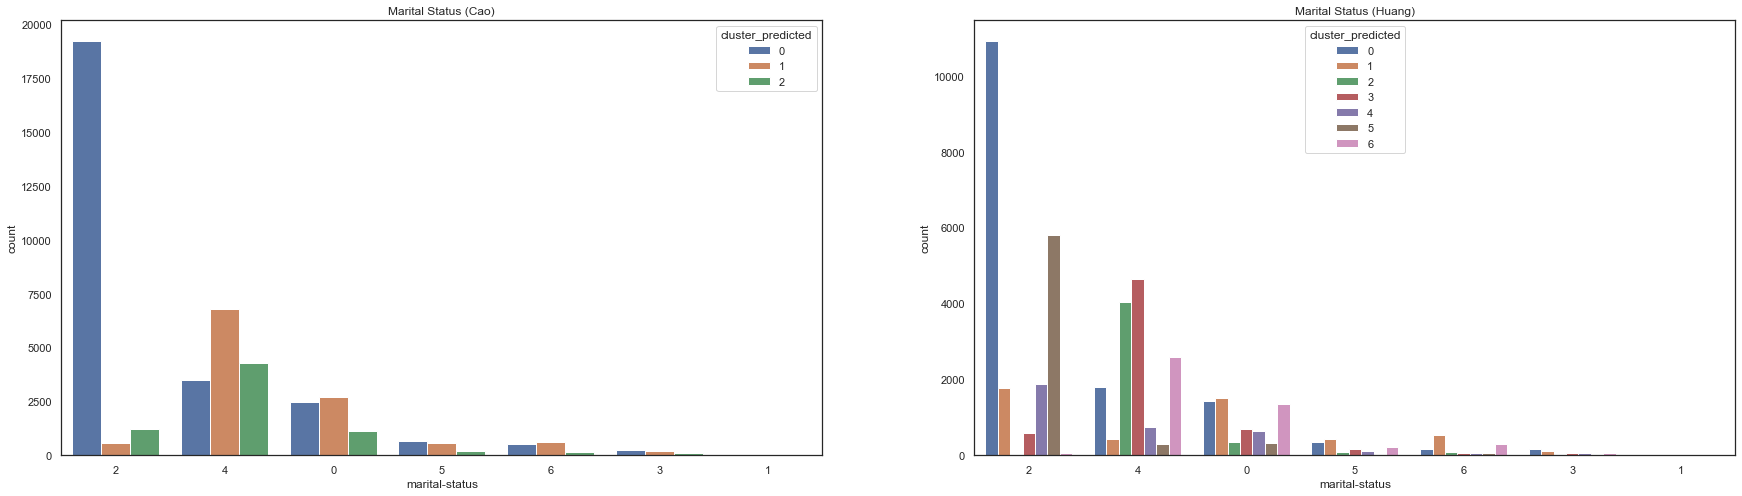

In [178]:
fig, ax = plt.subplots(1,2)
rcParams['figure.figsize'] = 30,8
sns.countplot(x=combinedDfcao['marital-status'],order=combinedDfcao['marital-status'].value_counts().index,hue=combinedDfcao['cluster_predicted'], ax = ax[0]).set(title="Marital Status (Cao)")
sns.countplot(x=combinedDfhuang['marital-status'],order=combinedDfhuang['marital-status'].value_counts().index,hue=combinedDfhuang['cluster_predicted'], ax = ax[1]).set(title="Marital Status (Huang)")
fig.show()

### Gender

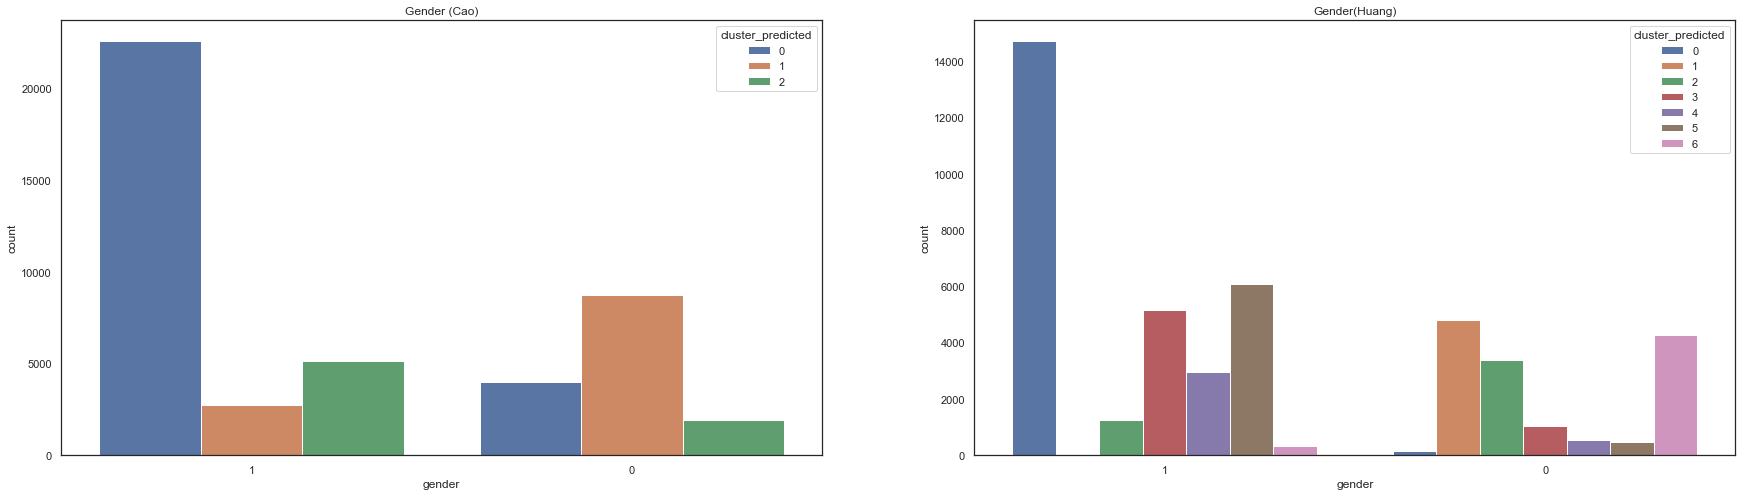

In [179]:
fig, ax = plt.subplots(1,2)
rcParams['figure.figsize'] = 30,8
sns.countplot(x=combinedDfcao['gender'],order=combinedDfcao['gender'].value_counts().index,hue=combinedDfcao['cluster_predicted'], ax = ax[0]).set(title="Gender (Cao)")
sns.countplot(x=combinedDfhuang['gender'],order=combinedDfhuang['gender'].value_counts().index,hue=combinedDfhuang['cluster_predicted'], ax = ax[1]).set(title= "Gender(Huang)")
fig.show()

### Work Class

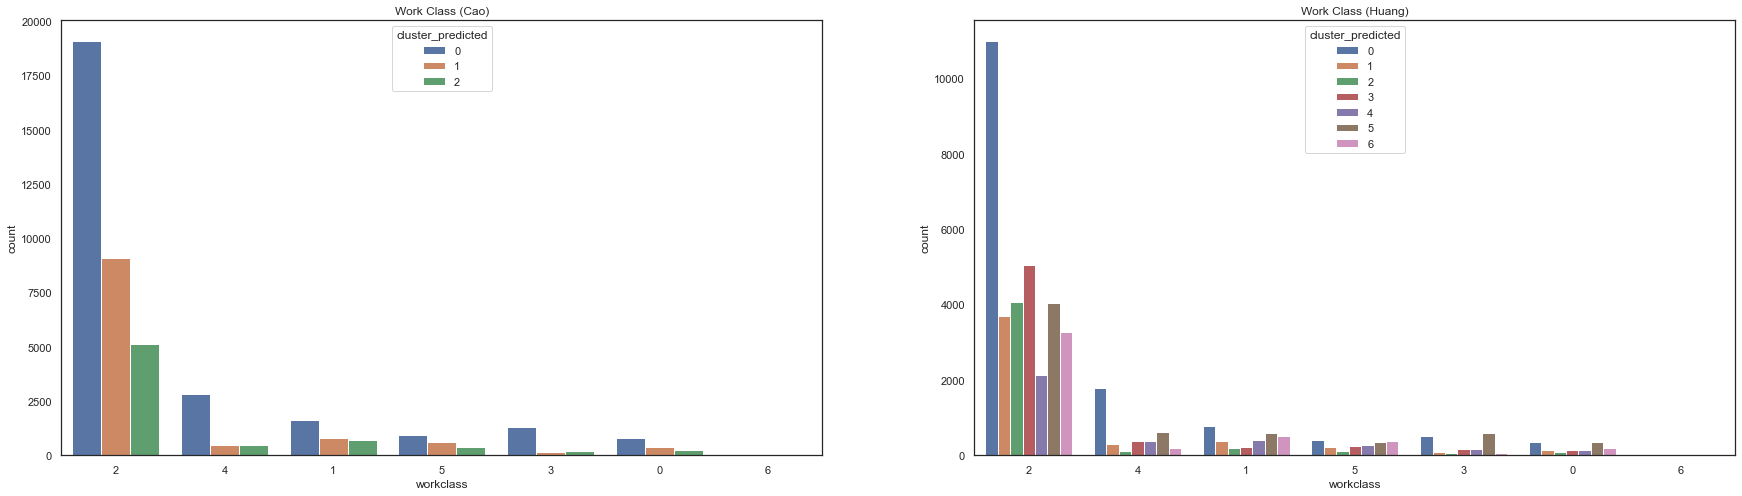

In [180]:
fig, ax = plt.subplots(1,2)
rcParams['figure.figsize'] = 30,8
sns.countplot(x=combinedDfcao['workclass'],order=combinedDfcao['workclass'].value_counts().index,hue=combinedDfcao['cluster_predicted'], ax = ax[0]).set(title="Work Class (Cao)")
sns.countplot(x=combinedDfhuang['workclass'],order=combinedDfhuang['workclass'].value_counts().index,hue=combinedDfhuang['cluster_predicted'], ax = ax[1]).set(title= "Work Class (Huang)")
fig.show()

## Modeling and Evaluation 4

A summary of a few of the interesting findings are highlighted below. In particularly there is interesting groupings along income, race, gender, hours worked, and marital status. 


* **Cao Cluster**
	- Age: 0 group has a higher age distribution then 1 and 2 which are reasonably close together.
	- Income: While the overall dataset balance of income was less than a third making > 50k income, group 0 has a larger portion of thos, closer to %35. Meanwhile group 1 has hardly any >50k income observations.
	- Hours Worked: Group 0 has the highest mean hours worked, which aligns with common sense that this group also has the highest proportion of high earners. Similarly, Group 1 has the lowest hours worked and the lowest proportion of high earners.
	- Education: Group 1 has by far the highest number of "some high school", while Group 2 has the most who have completed high school.  This aligns with expectations that the low earning group 1 has the worst amount of education compared to the other groups. 
	- Race: Proportions are similar across all groups for the most part. One potential takeaway is that the higher earning group 0 does appear to have a disproportiante amount of white. 
	- Marital Status: An interesting take away here is that the low earning group 1 has the most divorced and absent spouse observations. 
	- Gender: The low earning group 1 is disproportionately female compared to the other two groups. 
	
	
	
* **Huang Cluster**
	- Age: Groups 2 and 3 have a very young age mean whil ethe rest are reasonably close.
	- Income: Here we see the higher cluster count provide more homogenous groups. Group 5 is comprised only of >50k observations while group 2 has almost entirely < 50k income.
	- Hours Worked: Here again we see the relationship with income, with the high earning group 5 having the highest hours worked. Interestingly group 4 also has a large number of hours worked, despite having a small high earning proportion. 
	- Race: Similar to the Cao model, the high earning group 5 has a strong proportion of white and little diversity otherwise. 
	- Marital Status: The high earning group 5 is almost entirely civilian married observations. Interestingly the low earning, high hours worked group 4 has a relatively high proportion of divorced and absent spouse observations.
	- Gender: The exclusively high earning group 5 is disproportionately male. Group 1 is a homogenous female group. 

## Deployment

**Objective**

The main objective of the clustering model for this analysis is to try and create distinguished groups amongst the observations. The usefulness will vary depending on the types of groups created and where the modeling is able to distinguish separate clusters. 

One example of a use case would be for marketing purposes. If a group of observations fell strongly into the >50k income category, that group information can be used to target specific ads for higher priced products. This allows for an in between of one size fits all, and specific marketing for each customer. Instead of coming up with 50k add programs, you could create one for each group based on those demographics and target that way. 

Another potential use case of the clustering could be in better understanding the relationships between each other. For example, if there was a group that was majority never-married, you could look at other fields to see what other factors may be associated with it.

It is also a possibility that no particularly useful clusters will be able to be created, which could be a limitation of the methods used, or because there are in reality no strong connections. It is important to keep this possibility in mind to not try and "force" groups that make intuitive sense if the data does not back it up. 

* Both models were able to provide interesting insights and potentially useful groups, and in that way the goal of the analysis has been met. 
    * The Cao method with its smaller number of splits is still able to provide a decent seperation between gender, high/low income categories, as well as marital status. 
    * The Huang models complexity allows for more interesting insights and further room to explore. In particularly it allows for more specific group targeting, such as the exclusive high earning group or the long working hours and largely divorced or seperated group. 

* Some variables, such as work class and education, were harder to gain insights into and didn't appear to be usefully split in either models. 

**Deployment**

This data and model provides a strong foundation for various use cases. In the case of research, gaining more recent data to better explore changing trends could be of particular value, without having to bring in more variables. 

Other use cases, such as to help target marketing campaigns could benefit immensely with things like purchasing or behavior history data if available. That data, combined with demographic information similar to this dataset, could further help to gain understanding in what to market or develop for specific groups moving forward. The Huang model in particular would be a strong foundation for creating specific niche groups to categorize marketing campaings for. 


## Exceptional Work

For this section, in light of the recent [announcement](https://www.infoworld.com/article/3668630/rstudio-unveils-shiny-for-python.html) by Rstudio integrating Python into the Shiny framework, we decided to create a Shiny app to display the distribution of clusters for the most important attributes. The app takes the form a dropdown menu wherein the user may choose whichever variable they would like to display. What makes this application particularly intriguing is the processing of the plots in real time, rather than in a static png form, by the pandas and seaborn libraries.

The release, however, is still in its Alpha stage, so deployment to a server wasn't yet possible, but it is able to be run locally. We expect with future refinements and releases of the framework that people may be able to input a dataset and have a cluster analysis done in real-time. 

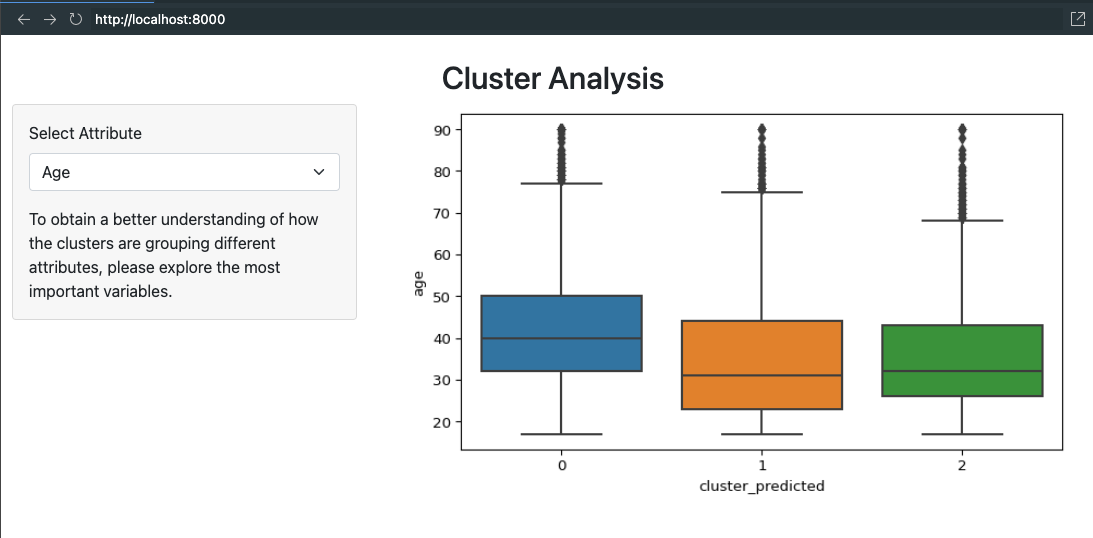

In [181]:
from IPython.display import Image
Image(filename='ss1.png') 


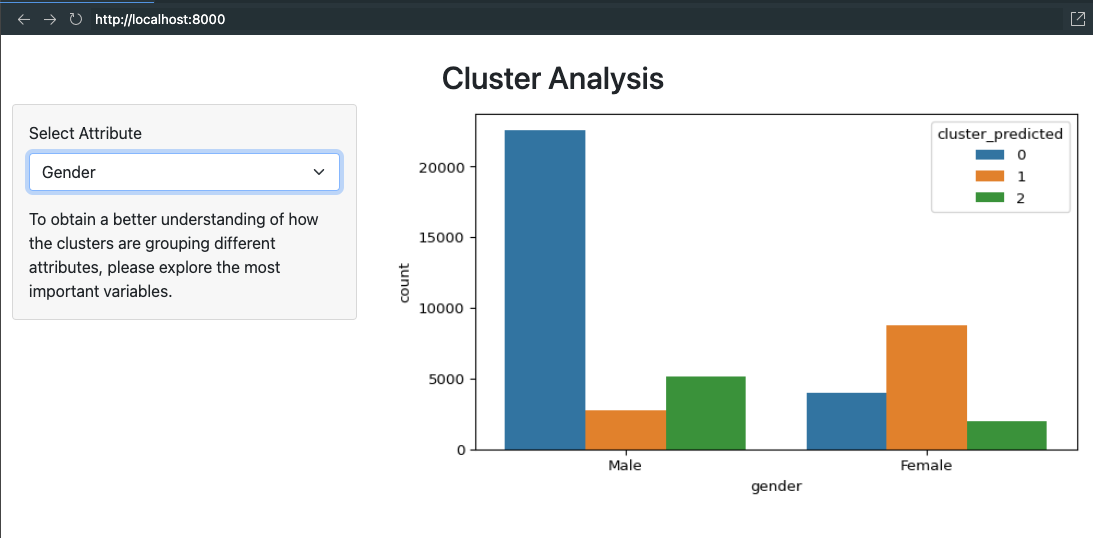

In [182]:
Image(filename='ss2.png')